Spearman ρ = 0.367, p = 5.24e-09


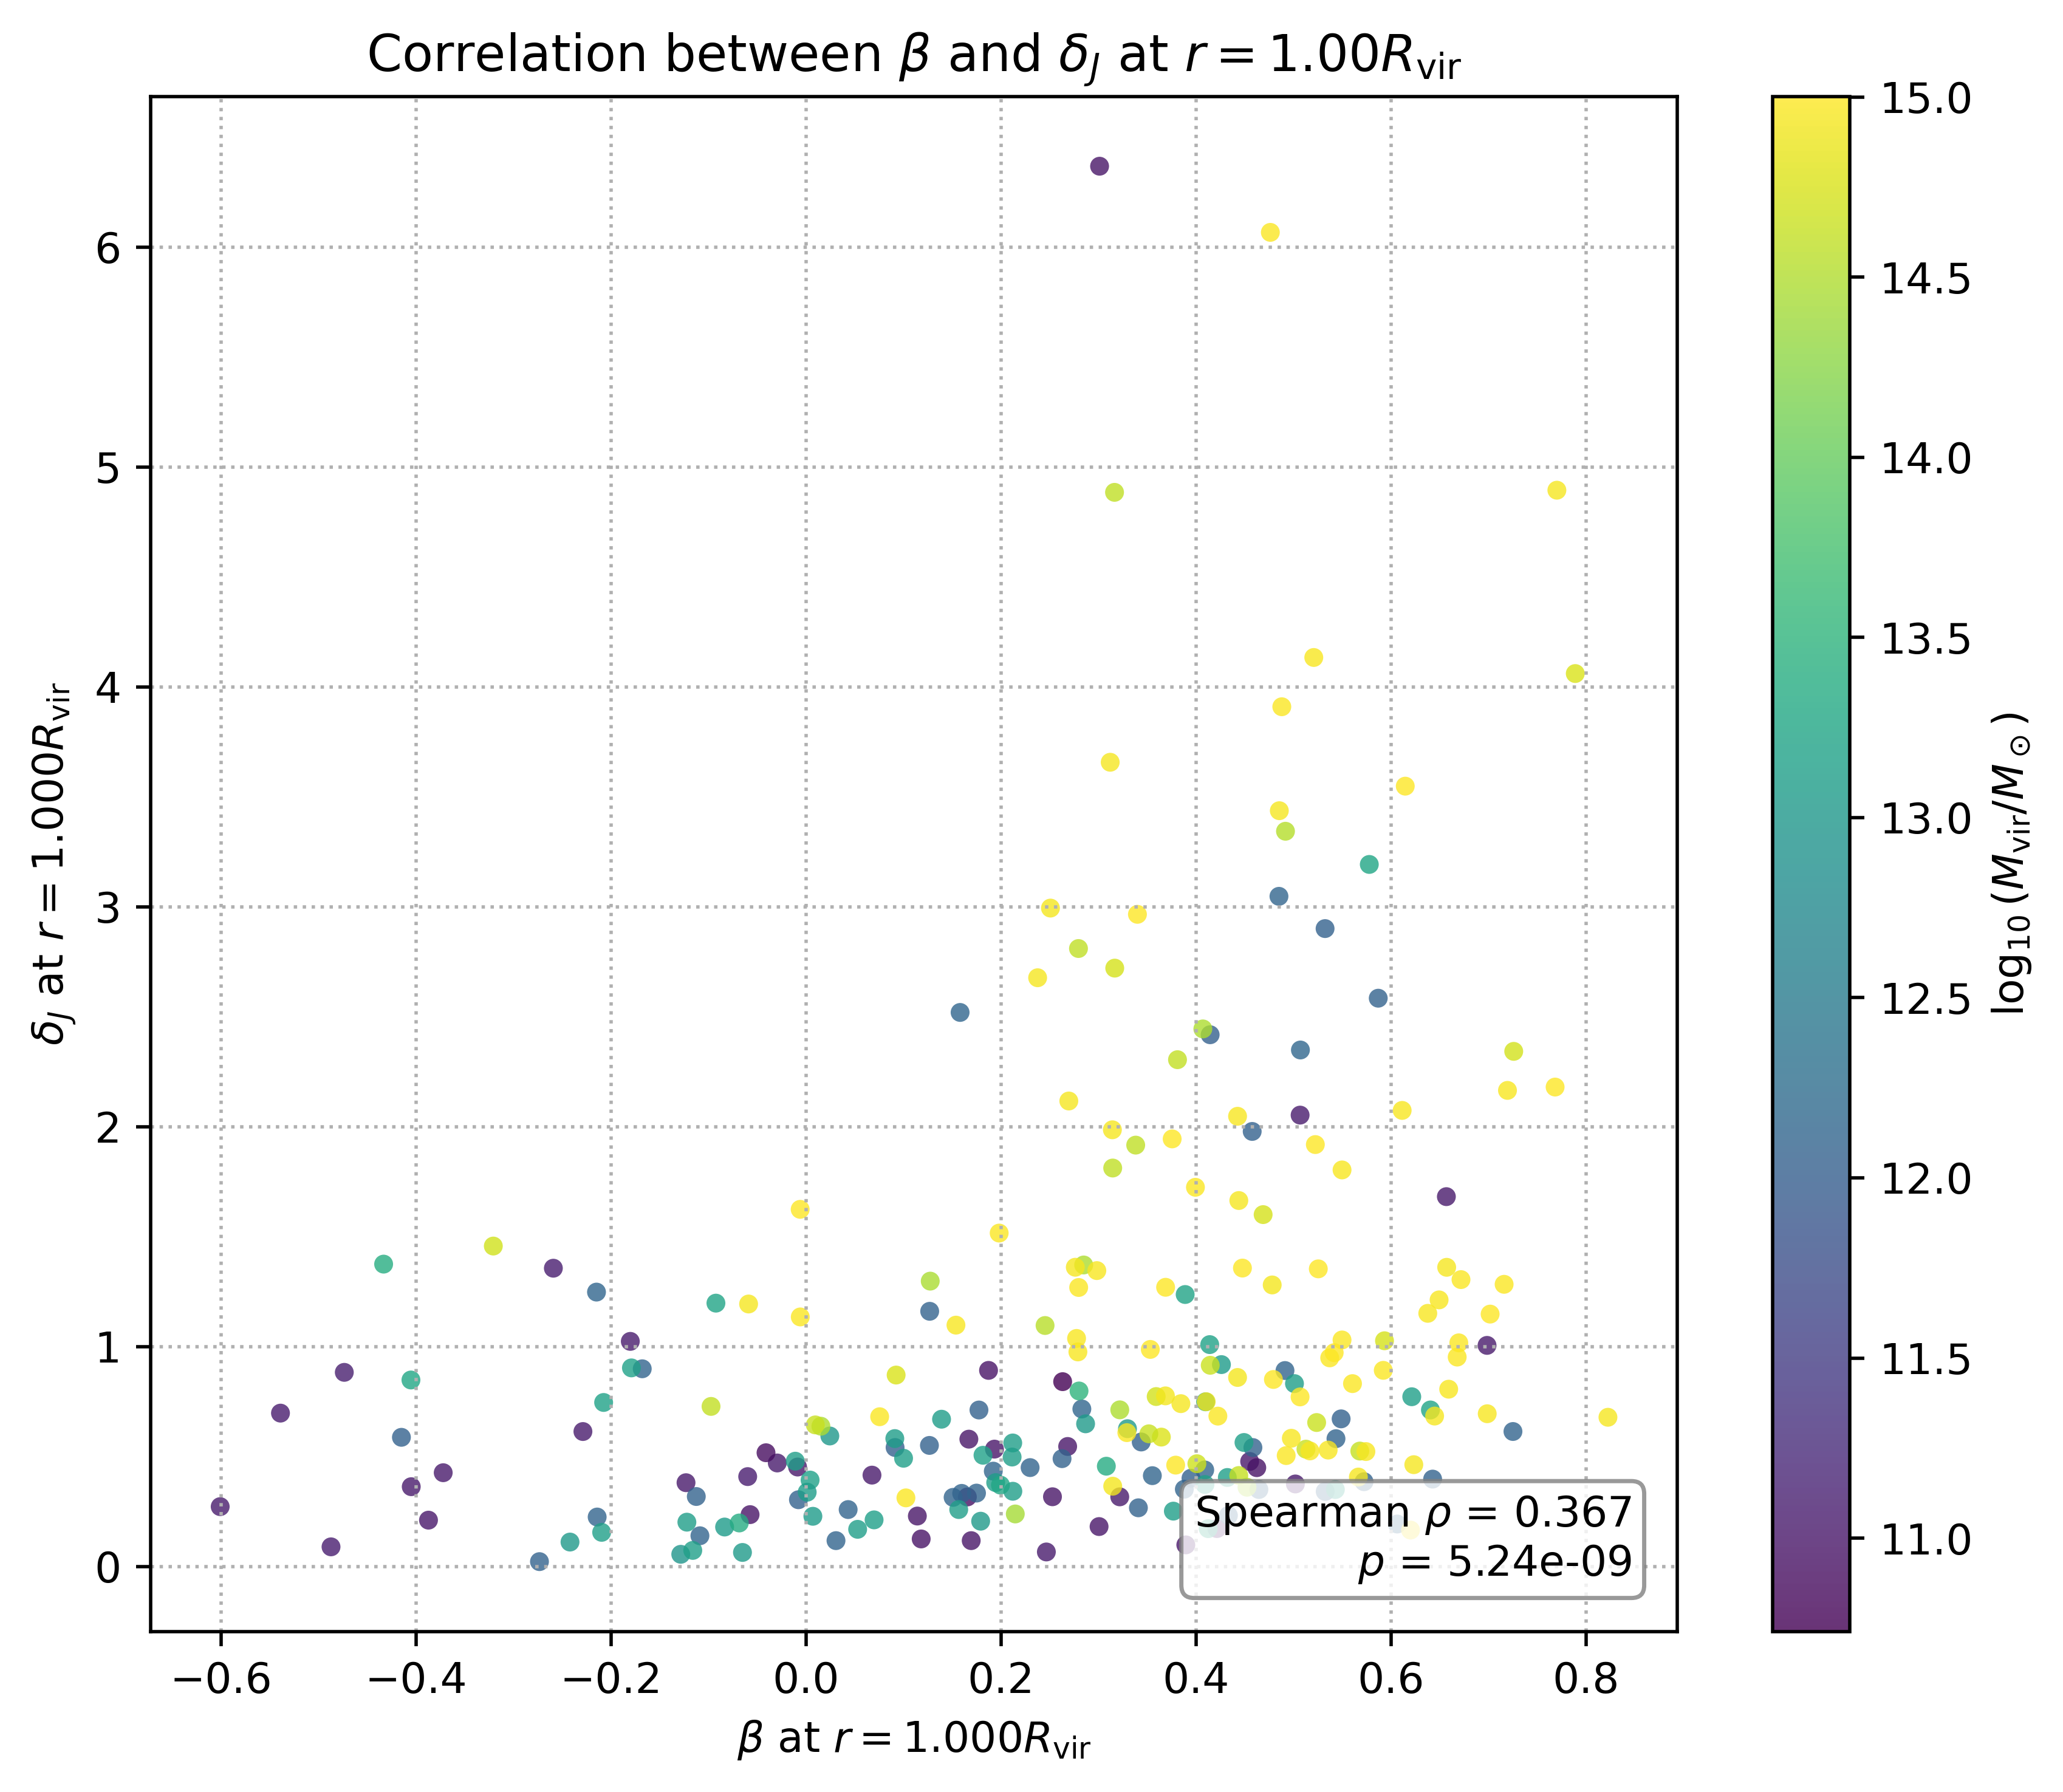

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import spearmanr

def plot_jeans_deviation_vs_beta(base_dir, suite_names, target_radius=0.1):
    beta_vals, delta_j_vals, mass_vals = [], [], []

    for suite in suite_names:
        velocity_dir = os.path.join(base_dir, "output", suite, "velocity_profiles")
        jeans_dir = os.path.join(base_dir, "output", suite, "jeans_deviation")
        mass_path = os.path.join(base_dir, "output", suite, "halo_mass.csv")
        mass_dict = dict(zip(pd.read_csv(mass_path)["halo_id"], 
                             pd.to_numeric(pd.read_csv(mass_path)["mvir"], errors='coerce')))

        for f in sorted(os.listdir(velocity_dir)):
            if not f.endswith(".csv"):
                continue
            try:
                halo_id = int(f.split("_")[1])
                vel_path = os.path.join(velocity_dir, f)
                jeans_path = os.path.join(jeans_dir, f.replace("velocity", "jeans"))

                df_vel = pd.read_csv(vel_path)
                df_jeans = pd.read_csv(jeans_path)

                r_vel = pd.to_numeric(df_vel["r_scaled"], errors='coerce').values
                beta = pd.to_numeric(df_vel["beta"], errors='coerce').values
                r_jeans = pd.to_numeric(df_jeans["r_scaled"], errors='coerce').values
                delta_j = pd.to_numeric(df_jeans["delta_J"], errors='coerce').values

                if len(r_vel) < 5 or len(r_jeans) < 5:
                    continue

                beta_interp = interp1d(r_vel, beta, bounds_error=False, fill_value=np.nan)
                delta_j_interp = interp1d(r_jeans, delta_j, bounds_error=False, fill_value=np.nan)

                beta_val = beta_interp(target_radius)
                delta_j_val = delta_j_interp(target_radius)
                mass_val = mass_dict.get(halo_id, np.nan)

                if np.isfinite(beta_val) and np.isfinite(delta_j_val) and np.isfinite(mass_val):
                    beta_vals.append(beta_val)
                    delta_j_vals.append(delta_j_val)
                    mass_vals.append(mass_val)
            except Exception as e:
                print(f"[Warning] Failed to process {f} in {suite}: {e}")
                continue

    beta_vals = np.array(beta_vals)
    delta_j_vals = np.array(delta_j_vals)
    log_mass = np.log10(np.array(mass_vals))

    if len(beta_vals) < 2:
        print("[Warning] Not enough valid data to plot.")
        return

    rho, pval = spearmanr(beta_vals, delta_j_vals)

    plt.figure(figsize=(7, 6), dpi=500)
    sc = plt.scatter(beta_vals, delta_j_vals, c=log_mass, cmap="viridis", s=20, alpha=0.8, edgecolors="none")
    plt.colorbar(sc, label=r"$\log_{10}(M_{\rm vir}/M_\odot)$")

    plt.xlabel(r"$\beta$ at $r = %.3f R_{\rm vir}$" % target_radius)
    plt.ylabel(r"$\delta_J$ at $r = %.3f R_{\rm vir}$" % target_radius)
    plt.title(r"Correlation between $\beta$ and $\delta_J$ at $r = %.2f R_{\rm vir}$" % target_radius)
    plt.grid(True, linestyle=":")
    plt.tight_layout()

    textstr = '\n'.join((
        rf"Spearman $\rho$ = {rho:.3f}",
        rf"$p$ = {pval:.2e}"
    ))
    plt.text(0.97, 0.03, textstr,
             transform=plt.gca().transAxes,
             fontsize=10, va='bottom', ha='right',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8))

    print(f"Spearman ρ = {rho:.3f}, p = {pval:.2e}")
    plt.show()

# Example usage:
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
plot_jeans_deviation_vs_beta(base_dir, suite_names, target_radius=1)

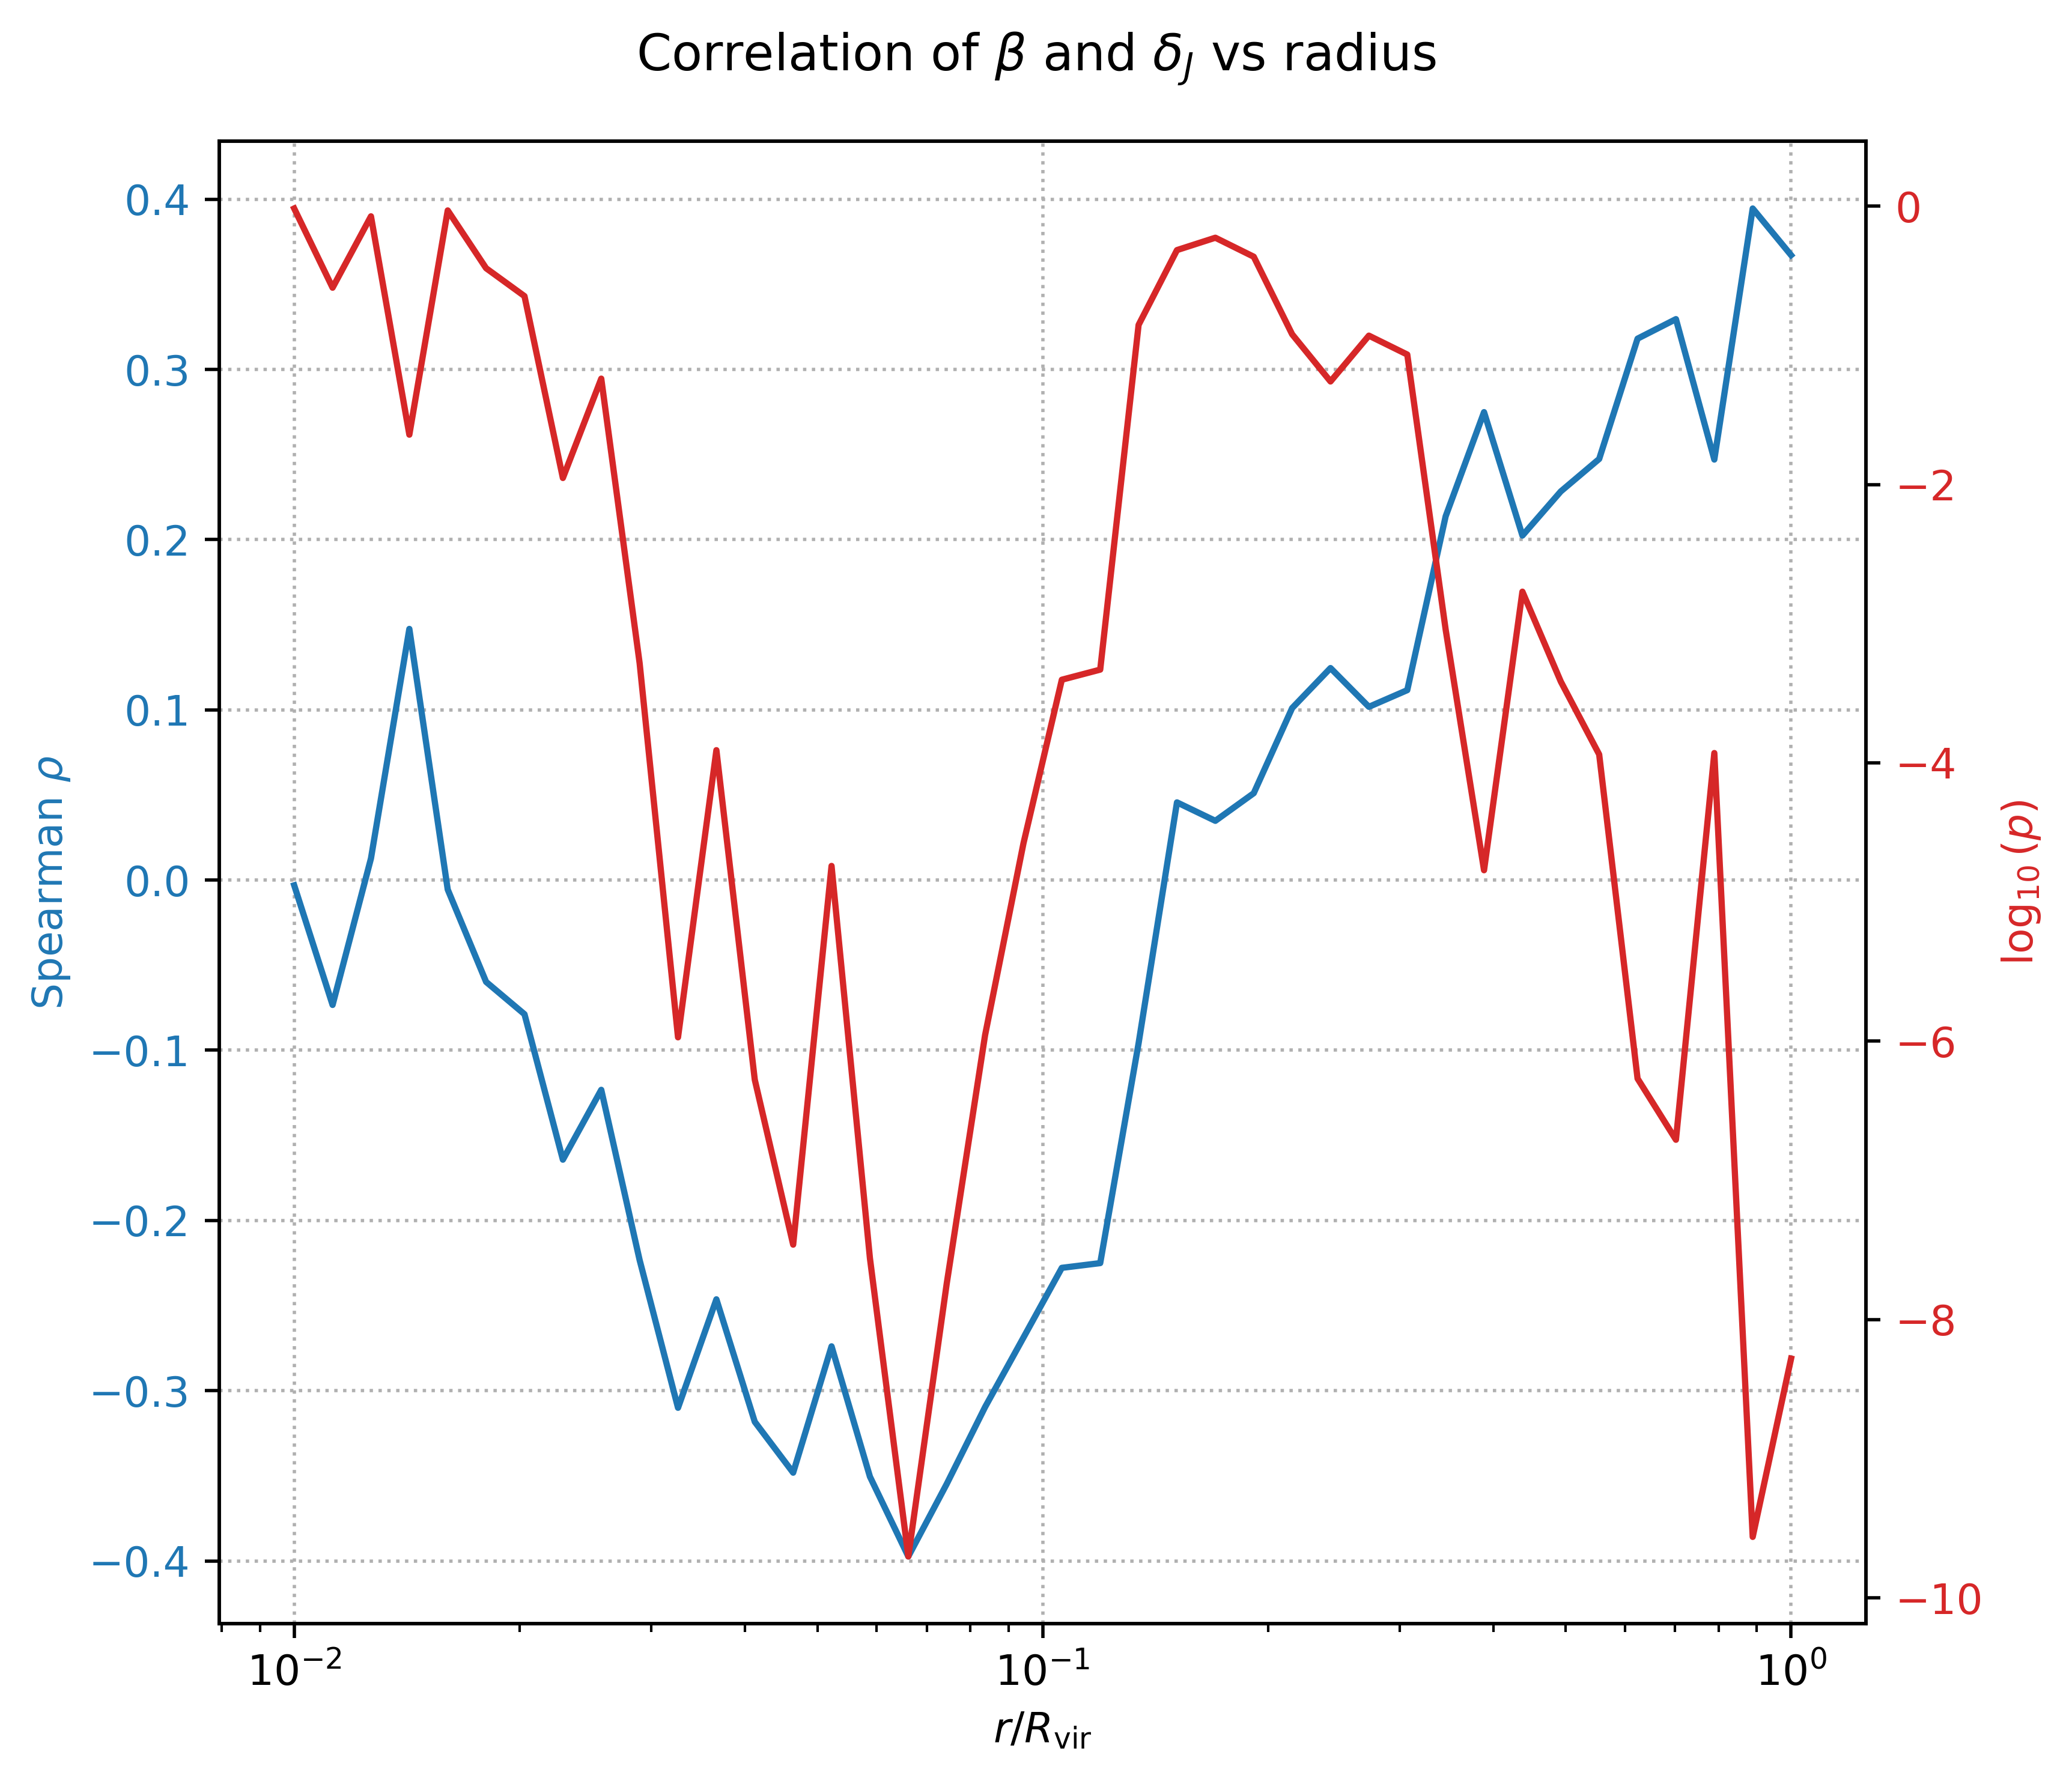

In [22]:
def plot_rho_and_p_vs_radius_beta_vs_jeans(base_dir, suite_names, r_bins=np.logspace(-2, 0, 40)):
    rho_list, p_list, r_mid_list = [], [], []

    for r in r_bins:
        beta_vals, delta_j_vals = [], []

        for suite in suite_names:
            velocity_dir = os.path.join(base_dir, "output", suite, "velocity_profiles")
            jeans_dir = os.path.join(base_dir, "output", suite, "jeans_deviation")

            for f in sorted(os.listdir(velocity_dir)):
                if not f.endswith(".csv"):
                    continue
                try:
                    halo_id = int(f.split("_")[1])
                    vel_path = os.path.join(velocity_dir, f)
                    jeans_path = os.path.join(jeans_dir, f.replace("velocity", "jeans"))

                    df_vel = pd.read_csv(vel_path)
                    df_jeans = pd.read_csv(jeans_path)

                    r_vel = pd.to_numeric(df_vel["r_scaled"], errors='coerce').values
                    beta = pd.to_numeric(df_vel["beta"], errors='coerce').values
                    r_jeans = pd.to_numeric(df_jeans["r_scaled"], errors='coerce').values
                    delta_j = pd.to_numeric(df_jeans["delta_J"], errors='coerce').values

                    if len(r_vel) < 5 or len(r_jeans) < 5:
                        continue

                    beta_interp = interp1d(r_vel, beta, bounds_error=False, fill_value=np.nan)
                    delta_j_interp = interp1d(r_jeans, delta_j, bounds_error=False, fill_value=np.nan)

                    beta_val = beta_interp(r)
                    delta_j_val = delta_j_interp(r)

                    if np.isfinite(beta_val) and np.isfinite(delta_j_val):
                        beta_vals.append(beta_val)
                        delta_j_vals.append(delta_j_val)

                except Exception as e:
                    continue

        if len(beta_vals) >= 5:
            rho, pval = spearmanr(beta_vals, delta_j_vals)
            rho_list.append(rho)
            p_list.append(pval)
            r_mid_list.append(r)

    # --- Plot ---
    fig, ax1 = plt.subplots(figsize=(7, 6), dpi=500)

    ax1.plot(r_mid_list, rho_list, label=r"Spearman $\rho$", color="tab:blue")
    ax1.set_xlabel(r"$r / R_{\rm vir}$")
    ax1.set_ylabel(r"Spearman $\rho$", color="tab:blue")
    ax1.tick_params(axis='y', labelcolor="tab:blue")
    ax1.set_xscale("log")
    ax1.grid(True, linestyle=":")

    # Right y-axis for log10(p)
    ax2 = ax1.twinx()
    ax2.plot(r_mid_list, np.log10(p_list), label=r"$\log_{10}(p)$", color="tab:red")
    ax2.set_ylabel(r"$\log_{10}(p)$", color="tab:red")
    ax2.tick_params(axis='y', labelcolor="tab:red")

    fig.suptitle(r"Correlation of $\beta$ and $\delta_J$ vs radius")
    fig.tight_layout()
    plt.show()

plot_rho_and_p_vs_radius_beta_vs_jeans(base_dir, suite_names)

Spearman ρ = -0.450, p = 3.96e-13


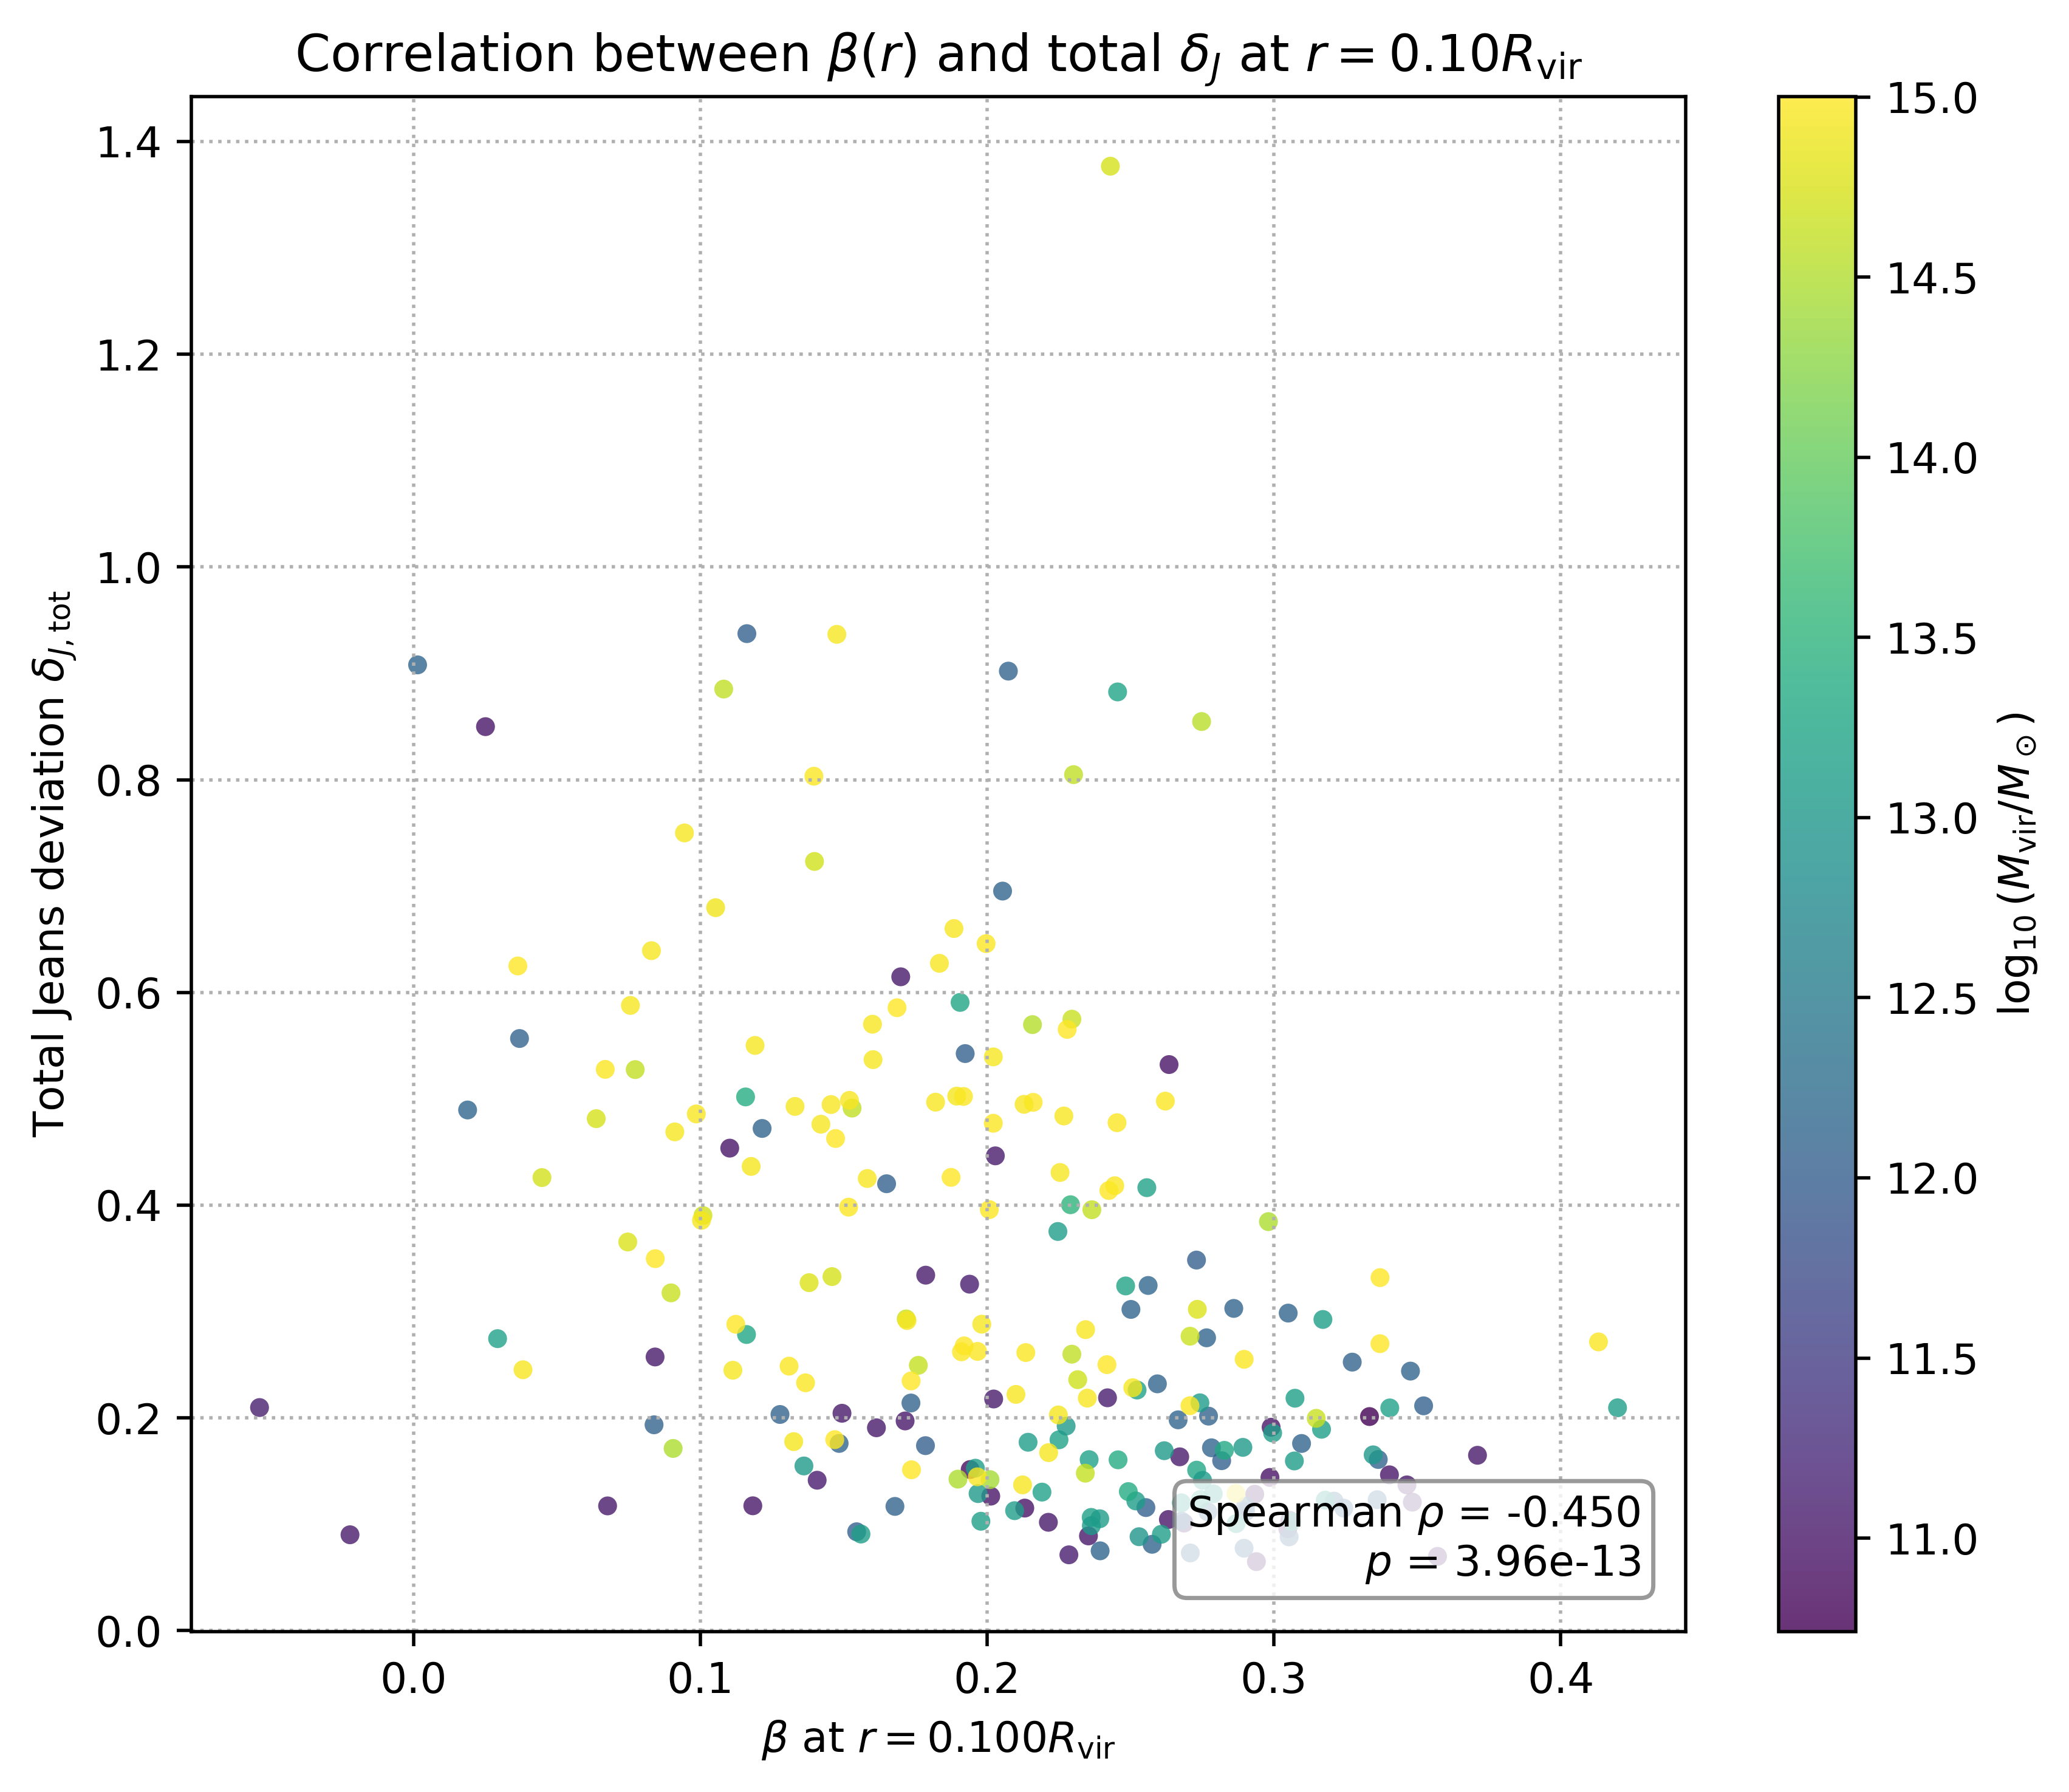

Spearman ρ = 0.352, p = 2.96e-08


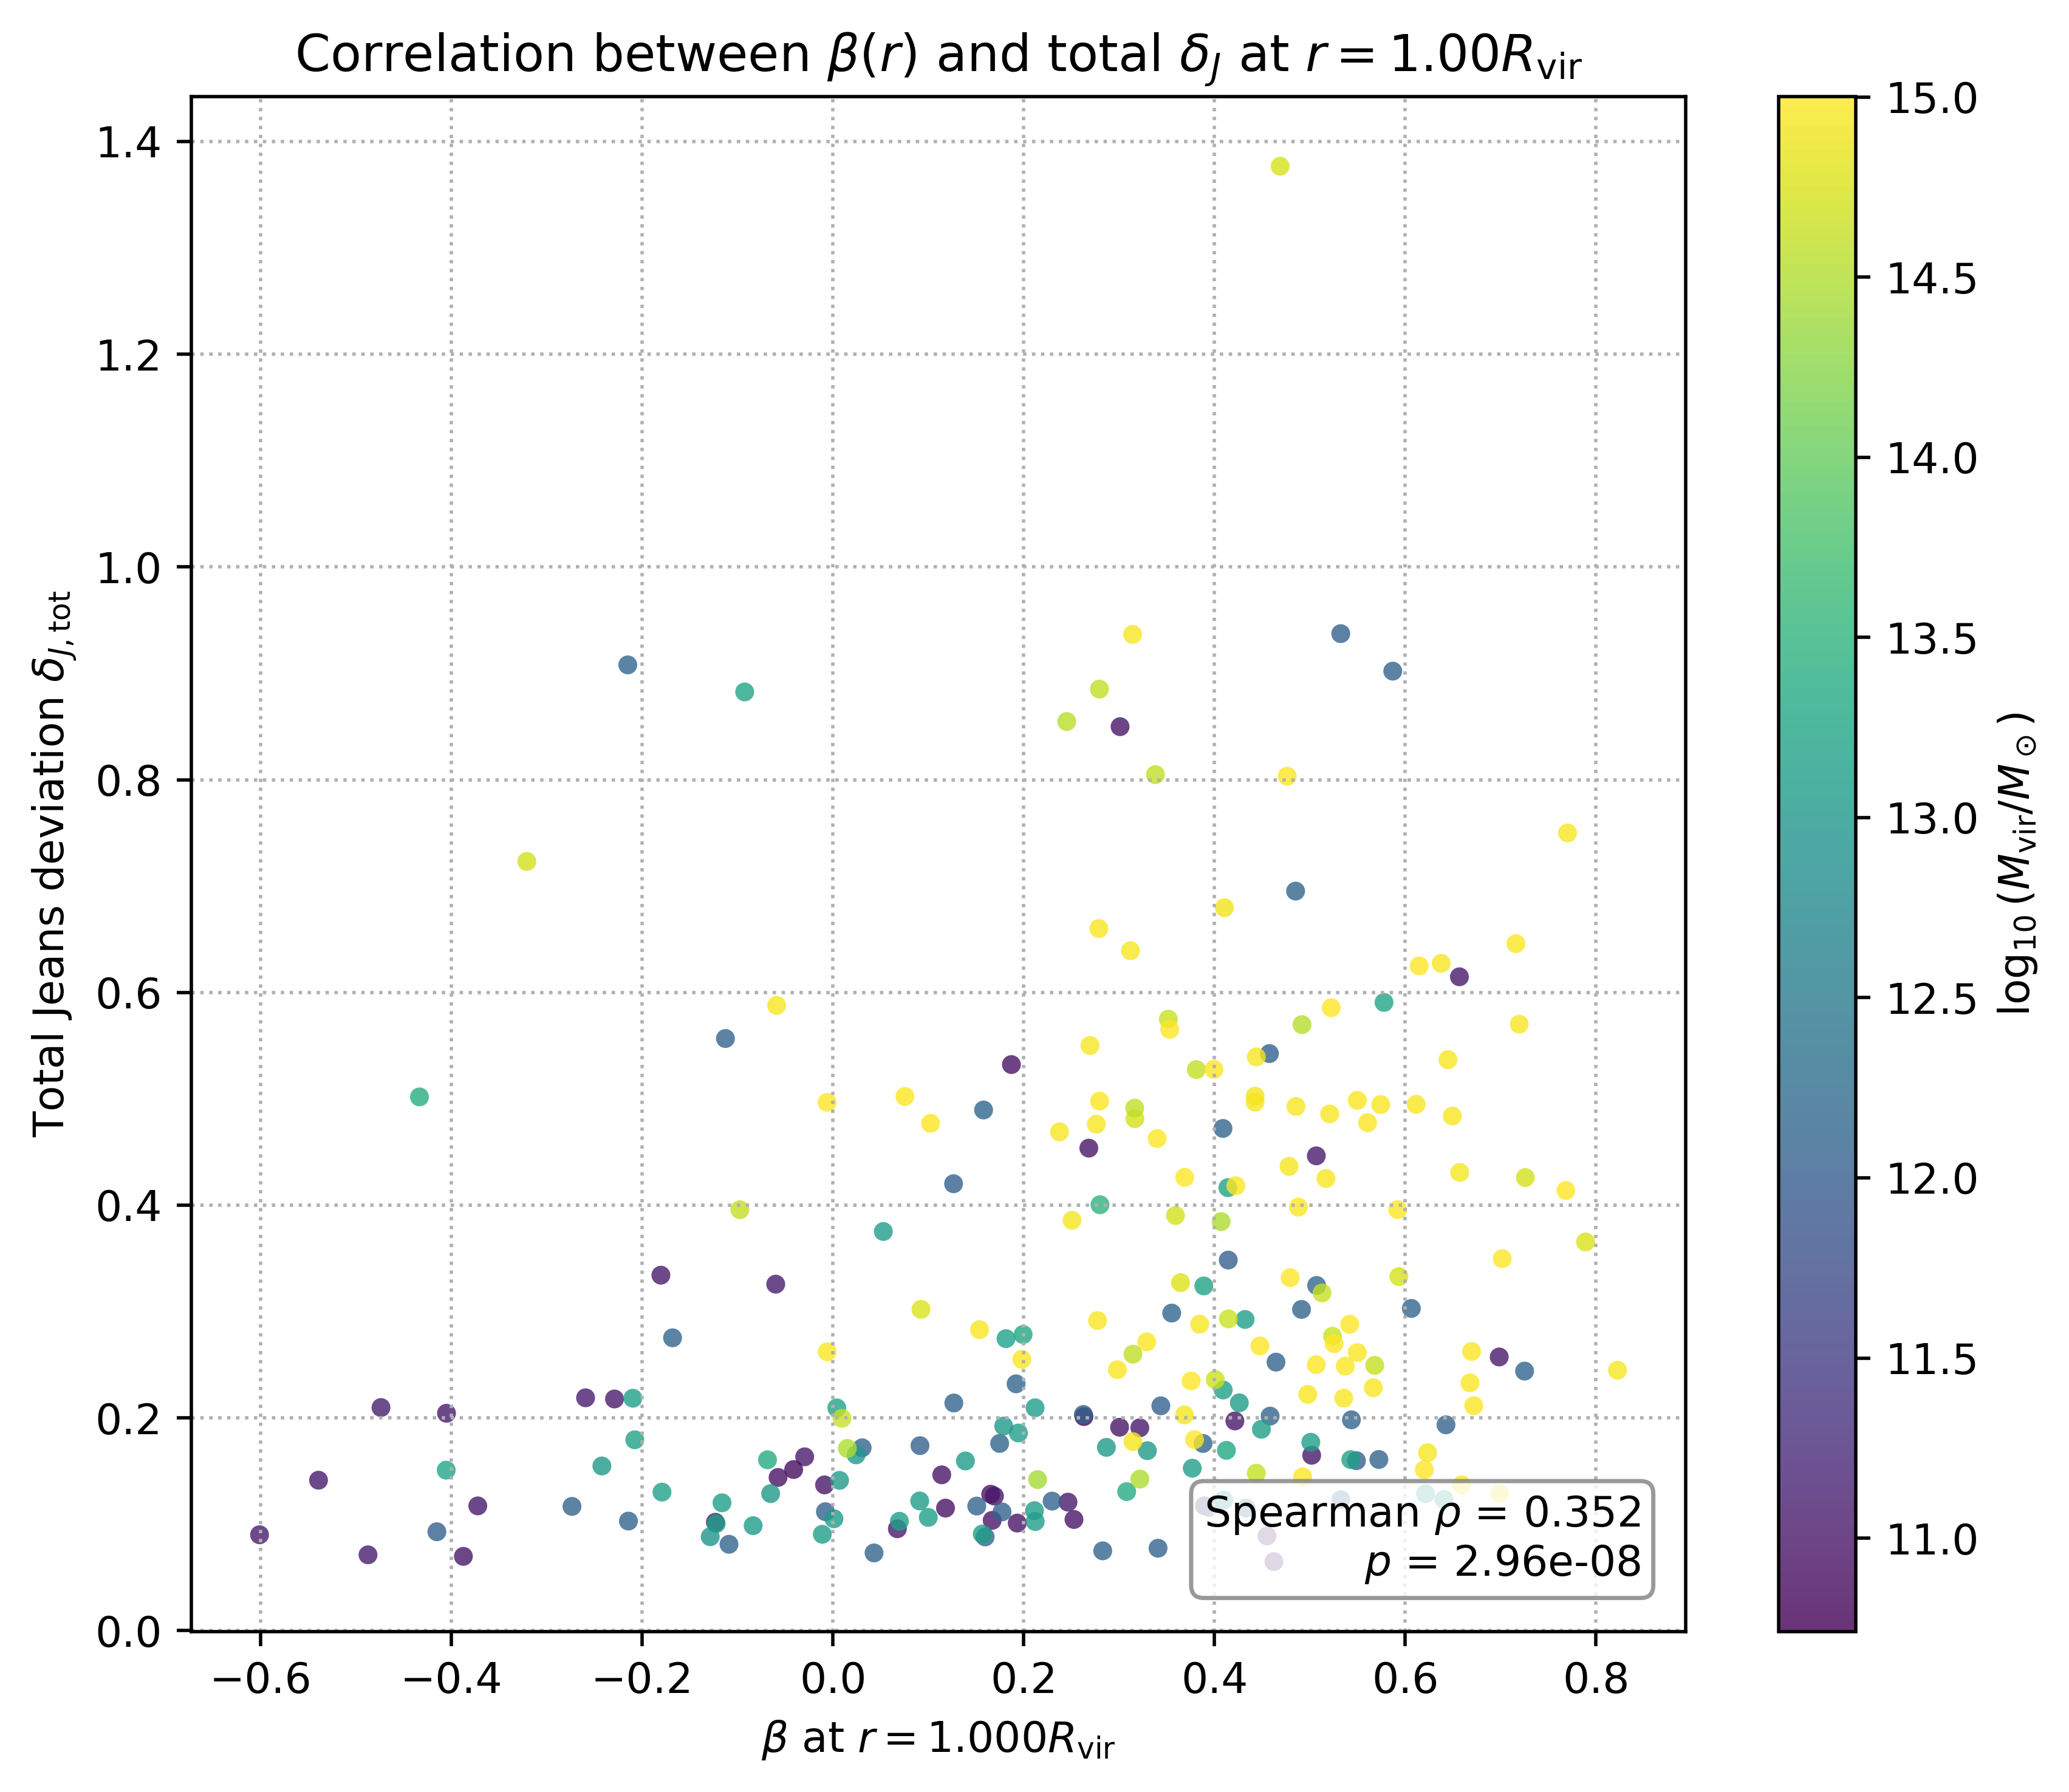

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import spearmanr

def plot_total_jeans_deviation_vs_beta(base_dir, suite_names, target_radius=0.1):
    beta_vals, delta_j_tot_vals, mass_vals = [], [], []

    for suite in suite_names:
        velocity_dir = os.path.join(base_dir, "output", suite, "velocity_profiles")
        jeans_tot_path = os.path.join(base_dir, "output", suite, "jeans_deviation_total.csv")
        mass_path = os.path.join(base_dir, "output", suite, "halo_mass.csv")

        df_jeans_tot = pd.read_csv(jeans_tot_path)
        jeans_tot_dict = dict(zip(df_jeans_tot["halo_id"], pd.to_numeric(df_jeans_tot["delta_J_tot"], errors='coerce')))

        df_mass = pd.read_csv(mass_path)
        mass_dict = dict(zip(df_mass["halo_id"], pd.to_numeric(df_mass["mvir"], errors='coerce')))

        for f in sorted(os.listdir(velocity_dir)):
            if not f.endswith(".csv"):
                continue
            try:
                halo_id = int(f.split("_")[1])
                vel_path = os.path.join(velocity_dir, f)
                df_vel = pd.read_csv(vel_path)

                r_vel = pd.to_numeric(df_vel["r_scaled"], errors='coerce').values
                beta = pd.to_numeric(df_vel["beta"], errors='coerce').values

                if len(r_vel) < 5:
                    continue

                beta_interp = interp1d(r_vel, beta, bounds_error=False, fill_value=np.nan)
                beta_val = beta_interp(target_radius)
                delta_j_tot = jeans_tot_dict.get(halo_id, np.nan)
                mass_val = mass_dict.get(halo_id, np.nan)

                if np.isfinite(beta_val) and np.isfinite(delta_j_tot) and np.isfinite(mass_val):
                    beta_vals.append(beta_val)
                    delta_j_tot_vals.append(delta_j_tot)
                    mass_vals.append(mass_val)

            except Exception as e:
                print(f"[Warning] Failed to process {f} in {suite}: {e}")
                continue

    beta_vals = np.array(beta_vals)
    delta_j_tot_vals = np.array(delta_j_tot_vals)
    log_mass = np.log10(np.array(mass_vals))

    if len(beta_vals) < 2:
        print("[Warning] Not enough valid data to plot.")
        return

    rho, pval = spearmanr(beta_vals, delta_j_tot_vals)

    plt.figure(figsize=(7, 6), dpi=500)
    sc = plt.scatter(beta_vals, delta_j_tot_vals, c=log_mass, cmap="viridis", s=20, alpha=0.8, edgecolors="none")
    plt.colorbar(sc, label=r"$\log_{10}(M_{\rm vir}/M_\odot)$")

    plt.xlabel(r"$\beta$ at $r = %.3f R_{\rm vir}$" % target_radius)
    plt.ylabel(r"Total Jeans deviation $\delta_{J, {\rm tot}}$")
    plt.title(r"Correlation between $\beta(r)$ and total $\delta_J$ at $r = %.2f R_{\rm vir}$" % target_radius)
    plt.grid(True, linestyle=":")
    plt.tight_layout()

    textstr = '\n'.join((
        rf"Spearman $\rho$ = {rho:.3f}",
        rf"$p$ = {pval:.2e}"
    ))
    plt.text(0.97, 0.03, textstr,
             transform=plt.gca().transAxes,
             fontsize=10, va='bottom', ha='right',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8))

    print(f"Spearman ρ = {rho:.3f}, p = {pval:.2e}")
    plt.show()

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]

plot_total_jeans_deviation_vs_beta(base_dir, suite_names, target_radius=0.1)
plot_total_jeans_deviation_vs_beta(base_dir, suite_names, target_radius=1)

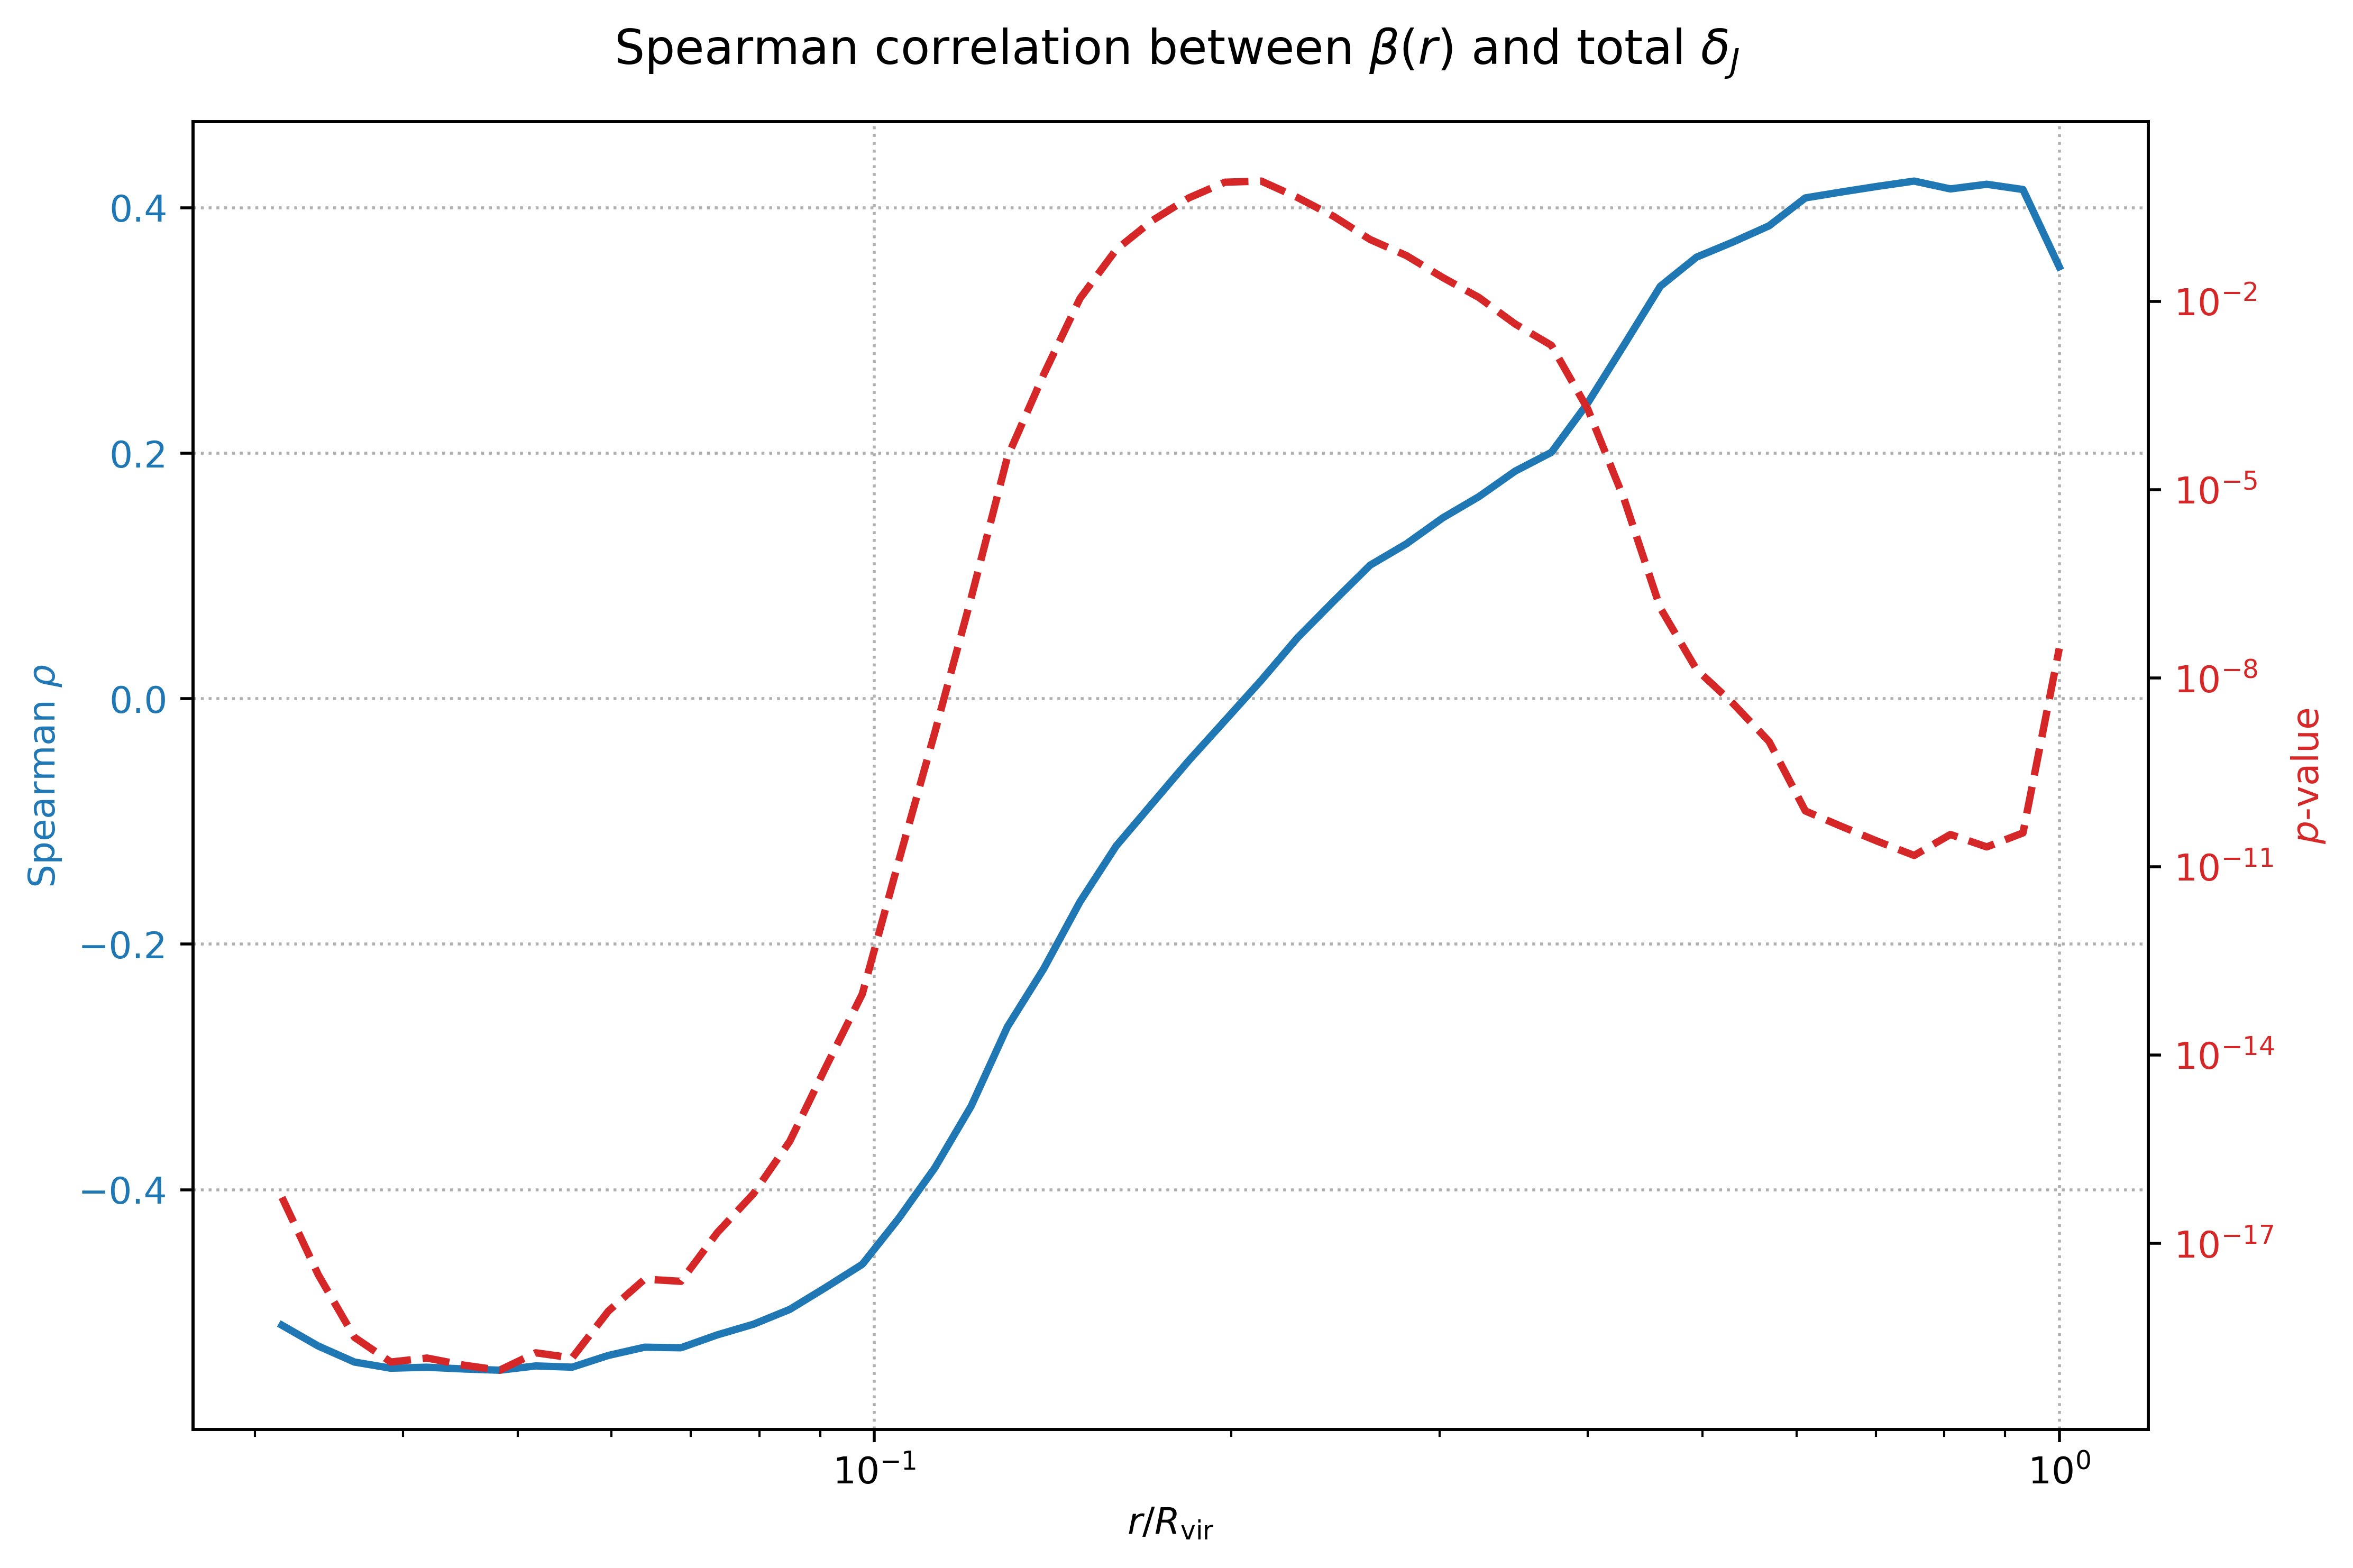

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def compute_spearman_vs_radius_for_total_jeans_deviation(base_dir, suite_names, r_bins=np.logspace(-1.5, 0, 50)):
    rho_list, pval_list, r_list = [], [], []

    for r_target in r_bins:
        beta_vals, delta_j_tot_vals = [], []

        for suite in suite_names:
            velocity_dir = os.path.join(base_dir, "output", suite, "velocity_profiles")
            jeans_tot_path = os.path.join(base_dir, "output", suite, "jeans_deviation_total.csv")

            try:
                df_jeans_tot = pd.read_csv(jeans_tot_path)
                jeans_tot_dict = dict(zip(df_jeans_tot["halo_id"], pd.to_numeric(df_jeans_tot["delta_J_tot"], errors='coerce')))
            except Exception as e:
                print(f"[Warning] Failed to read Jeans file for {suite}: {e}")
                continue

            for f in sorted(os.listdir(velocity_dir)):
                if not f.endswith(".csv"):
                    continue
                try:
                    halo_id = int(f.split("_")[1])
                    df_vel = pd.read_csv(os.path.join(velocity_dir, f))

                    r = pd.to_numeric(df_vel["r_scaled"], errors='coerce').values
                    beta = pd.to_numeric(df_vel["beta"], errors='coerce').values
                    if len(r) < 5:
                        continue

                    beta_interp = np.interp(r_target, r, beta, left=np.nan, right=np.nan)
                    delta_j_tot = jeans_tot_dict.get(halo_id, np.nan)

                    if np.isfinite(beta_interp) and np.isfinite(delta_j_tot):
                        beta_vals.append(beta_interp)
                        delta_j_tot_vals.append(delta_j_tot)
                except Exception as e:
                    print(f"[Warning] Failed to process {f} in {suite}: {e}")
                    continue

        beta_vals = np.array(beta_vals)
        delta_j_tot_vals = np.array(delta_j_tot_vals)
        if len(beta_vals) >= 5:
            rho, pval = spearmanr(beta_vals, delta_j_tot_vals)
        else:
            rho, pval = np.nan, np.nan

        rho_list.append(rho)
        pval_list.append(pval)
        r_list.append(r_target)

    rho_arr = np.array(rho_list)
    pval_arr = np.array(pval_list)
    r_arr = np.array(r_list)

    # --- Plot ---
    fig, ax1 = plt.subplots(figsize=(9, 6), dpi=500)

    color_rho = "tab:blue"
    ax1.set_xlabel(r"$r / R_{\rm vir}$")
    ax1.set_ylabel(r"Spearman $\rho$", color=color_rho)
    ax1.plot(r_arr, rho_arr, label=r"Spearman $\rho$", color=color_rho, lw=2)
    ax1.tick_params(axis='y', labelcolor=color_rho)
    ax1.set_xscale("log")
    ax1.grid(True, linestyle=":")

    # --- Right axis for p-values ---
    ax2 = ax1.twinx()
    color_pval = "tab:red"
    ax2.set_ylabel(r"$p$-value", color=color_pval)
    ax2.plot(r_arr, pval_arr, label=r"$p$-value", color=color_pval, lw=2, linestyle="--")
    ax2.set_yscale("log")
    ax2.tick_params(axis='y', labelcolor=color_pval)

    # --- Title and layout ---
    fig.suptitle(r"Spearman correlation between $\beta(r)$ and total $\delta_J$", fontsize=13)
    fig.tight_layout()
    fig.subplots_adjust(top=0.92)  # Make room for title

    plt.show()

    return r_arr, rho_arr, pval_arr

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
r, rho, p = compute_spearman_vs_radius_for_total_jeans_deviation(base_dir, suite_names)

Spearman ρ = 0.139, p = 3.33e-02


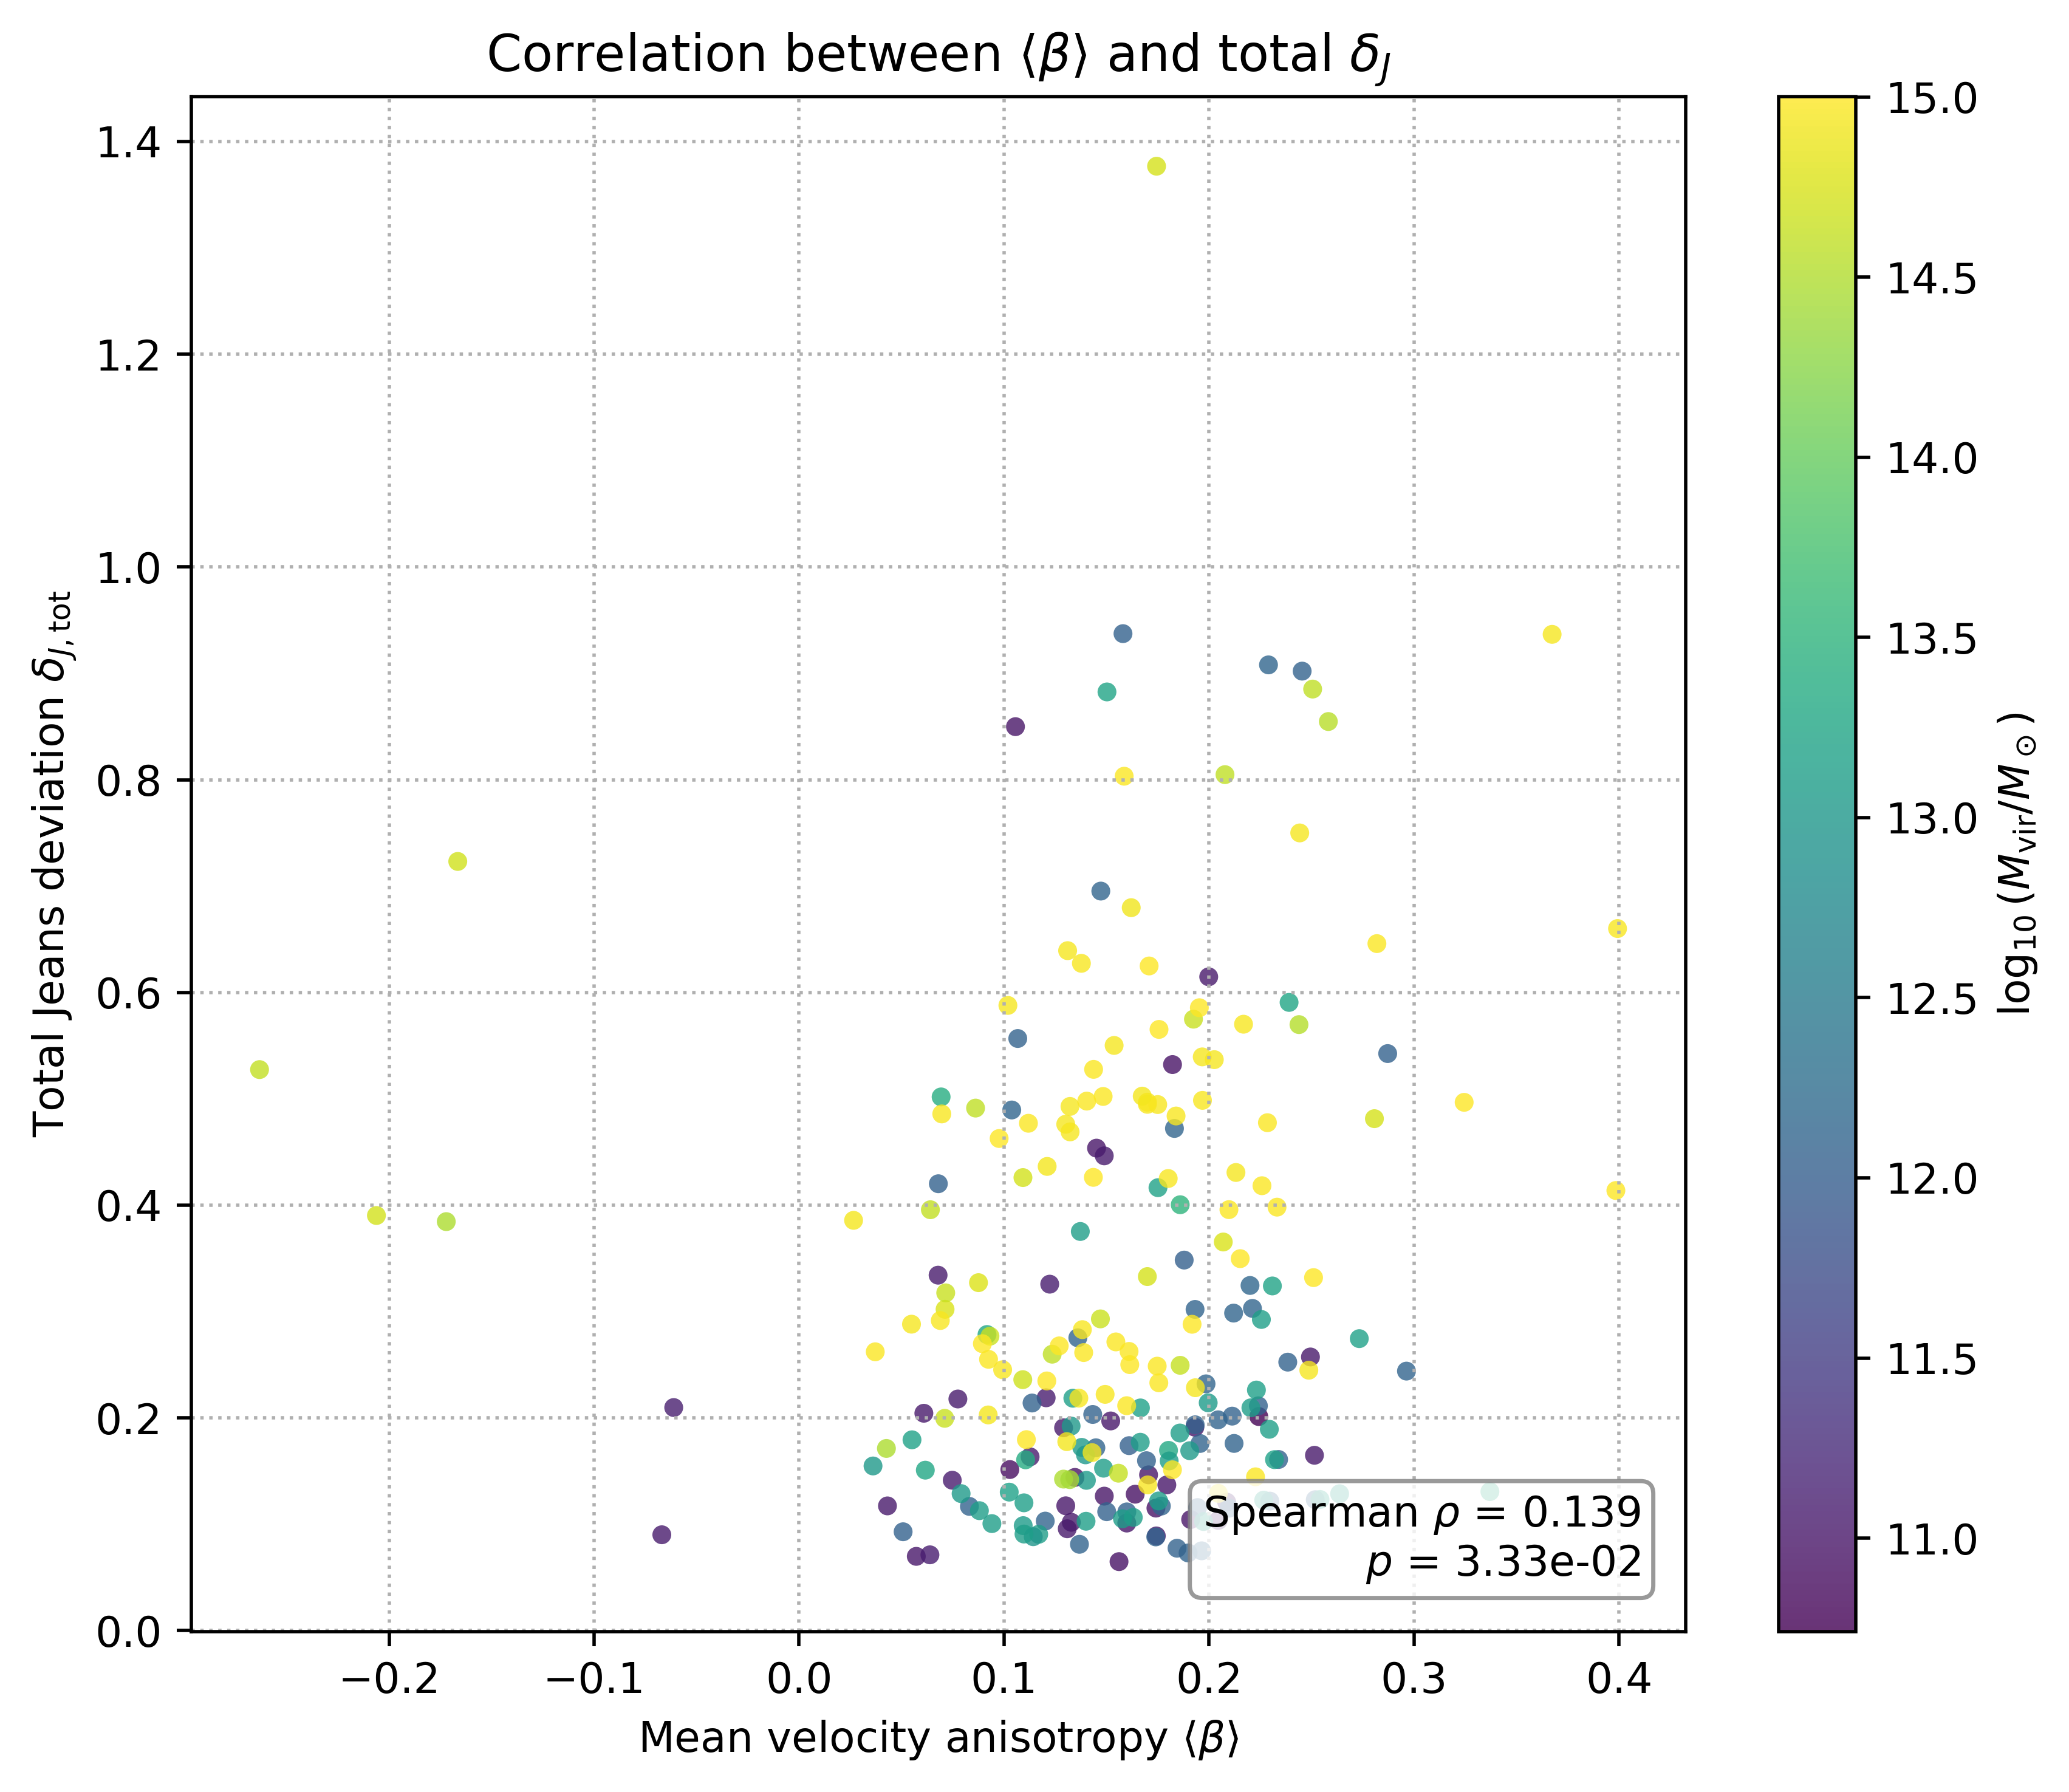

In [17]:
def plot_mean_beta_vs_total_jeans_deviation(base_dir, suite_names):
    mean_beta_vals, delta_j_tot_vals, mass_vals = [], [], []

    for suite in suite_names:
        velocity_dir = os.path.join(base_dir, "output", suite, "velocity_profiles")
        jeans_tot_path = os.path.join(base_dir, "output", suite, "jeans_deviation_total.csv")
        mass_path = os.path.join(base_dir, "output", suite, "halo_mass.csv")

        df_jeans_tot = pd.read_csv(jeans_tot_path)
        jeans_tot_dict = dict(zip(df_jeans_tot["halo_id"], pd.to_numeric(df_jeans_tot["delta_J_tot"], errors='coerce')))

        df_mass = pd.read_csv(mass_path)
        mass_dict = dict(zip(df_mass["halo_id"], pd.to_numeric(df_mass["mvir"], errors='coerce')))

        for f in sorted(os.listdir(velocity_dir)):
            if not f.endswith(".csv"):
                continue
            try:
                halo_id = int(f.split("_")[1])
                vel_path = os.path.join(velocity_dir, f)
                df_vel = pd.read_csv(vel_path)

                beta = pd.to_numeric(df_vel["beta"], errors='coerce').values
                delta_j_tot = jeans_tot_dict.get(halo_id, np.nan)
                mass_val = mass_dict.get(halo_id, np.nan)

                if len(beta) < 5:
                    continue

                mean_beta = np.nanmean(beta)

                if np.isfinite(mean_beta) and np.isfinite(delta_j_tot) and np.isfinite(mass_val):
                    mean_beta_vals.append(mean_beta)
                    delta_j_tot_vals.append(delta_j_tot)
                    mass_vals.append(mass_val)

            except Exception as e:
                print(f"[Warning] Failed to process {f} in {suite}: {e}")
                continue

    mean_beta_vals = np.array(mean_beta_vals)
    delta_j_tot_vals = np.array(delta_j_tot_vals)
    log_mass = np.log10(np.array(mass_vals))

    if len(mean_beta_vals) < 2:
        print("[Warning] Not enough valid data to plot.")
        return

    rho, pval = spearmanr(mean_beta_vals, delta_j_tot_vals)

    plt.figure(figsize=(7, 6), dpi=500)
    sc = plt.scatter(mean_beta_vals, delta_j_tot_vals, c=log_mass, cmap="viridis", s=20, alpha=0.8, edgecolors="none")
    plt.colorbar(sc, label=r"$\log_{10}(M_{\rm vir}/M_\odot)$")

    plt.xlabel(r"Mean velocity anisotropy $\langle \beta \rangle$")
    plt.ylabel(r"Total Jeans deviation $\delta_{J, {\rm tot}}$")
    plt.title(r"Correlation between $\langle \beta \rangle$ and total $\delta_J$")
    plt.grid(True, linestyle=":")
    plt.tight_layout()

    textstr = '\n'.join((
        rf"Spearman $\rho$ = {rho:.3f}",
        rf"$p$ = {pval:.2e}"
    ))
    plt.text(0.97, 0.03, textstr,
             transform=plt.gca().transAxes,
             fontsize=10, va='bottom', ha='right',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8))

    print(f"Spearman ρ = {rho:.3f}, p = {pval:.2e}")
    plt.show()
    
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
plot_mean_beta_vs_total_jeans_deviation(base_dir, suite_names)